# Joint mark-recapture CPUE model for crown of thorns abundance estimates on the GBR

One of the largest gaps in understanding crown of thorns starfish (CoTS) population dynamics is the lack of information concerning their abundance at any given point in time. While surveys such as AIMS long-term monitoring program (LTMP) were originally designed to detect the presence of CoTS outbreaks, little has been accomplished in recent years towards integrating the various data sets currently collected.

Here we utilise the posteriors of our joint Bayesian hierarchial model for estimating the detectabilty of CoTS adults and integrate available datasets to improve CoTS population estimates in the Cairns sector of the GBR.

Currently there are four sources for CoTS density information:

1. *QPWS RHIS surveys* - The [Queensland Parks and Wildlife Service](http://www.nprsr.qld.gov.au/world-heritage-areas/great_barrier_reef.html) conducts ongoing surveys as part of GBRMPA's the Eye on the Reef / Field Monitoring program.
2. *AMPTO surveys* - The [The Association of Marine Park Tourism Operators](http://www.ampto.com.au) conducts ongoing [kill operations](http://www.ampto.com.au/cots.htm) in an effort to eradicate CoTS from high-value tourisim reefs within the GBR
3. *AIMS manta surveys* - The [Australian Institute of Marine Science](http://www.aims.gov.au/docs/research/biodiversity-ecology/threats/cots.html) conducts annual surveys along the entire GBR, one component of which is to conduct manta tow surveys around the perimiter of survey reefs, looking for CoTS (not used here)
4. *Other researchers* - Various additional data sources exist where scientists and the public report CoTS information to a relevant scientific or management body (not used here)

Each of these data sources contain information concerning the abundance of CoTS on the GBR, however two key gaps in understanding lies in a) what is the detectabilty of an individual starfish in a survey, given that it is there, and b) how should these various data sources be integrated?

Here we will build a Bayesian model that is flexible enough to address both gaps, using mark-recapture surveys from May of 2014 to estimate CoTS detectability and both AMPTO and QPWS surveyed the same reef sites so as to calibrate their approach to a population of (approximately) known size.

The Bayesian hierarchical model models we're going to build will be done using the [PyMC](http://pymc-devs.github.io/pymc/) package for the [Python](https://www.python.org) programming language. Both are open-source and freely accessable. 

### Data wrangling

The first step is to import the required python packages:

In [ ]:
# Import python packages
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from mpl_toolkits.basemap import Basemap as bm
import datetime as dt
import pymc as pm
import math as ma
from scipy.special import gamma as gammaf
from scipy.misc import factorial as ft

And a few custom scripts

In [ ]:
# Helper functions
def indexall(L):
    poo = []
    for p in L:
        if not p in poo:
            poo.append(p)
    Ix = np.array([poo.index(p) for p in L])
    return poo,Ix

def subindexall(short,long):
    poo = []
    out = []
    for s,l in zip(short,long):
        if not l in poo:
            poo.append(l)
            out.append(s)
    return indexall(out)

match = lambda a, b: np.array([ b.index(x) if x in b else None for x in a ])


def DoUS(lat1, long1, lat2, long2):
    # From John Cook: http://www.johndcook.com/blog/python_longitude_latitude/
    # Convert latitude and longitude to 
    # spherical coordinates in radians.
    degrees_to_radians = ma.pi/180.0
         
    # phi = 90 - latitude
    phi1 = (90.0 - lat1)*degrees_to_radians
    phi2 = (90.0 - lat2)*degrees_to_radians
         
    # theta = longitude
    theta1 = long1*degrees_to_radians
    theta2 = long2*degrees_to_radians
         
    # Compute spherical distance from spherical coordinates.
         
    # For two locations in spherical coordinates 
    # (1, theta, phi) and (1, theta', phi')
    # cosine( arc length ) = 
    #    sin phi sin phi' cos(theta-theta') + cos phi cos phi'
    # distance = rho * arc length
     
    cos = (ma.sin(phi1)*ma.sin(phi2)*ma.cos(theta1 - theta2) + 
           ma.cos(phi1)*ma.cos(phi2))
    arc = ma.acos( cos )
 
    # Remember to multiply arc by the radius of the earth 
    # in your favorite set of units to get length.
    return arc*6373

The next step is to import the mark-recapture data:

In [ ]:
# Import QPWS data
cdata = pd.read_csv('mantaswimRHIS.df.csv')
# Column names
cdata.columns.values

In [ ]:
# Import AMPTO data
adata = pd.read_csv('AMPTO.csv')
# Column names
adata.columns.values

Here we have two datasets with information from both regular monitoring (QPWS) and the culling operations (AMPTO).

Dealing with the QPWS data first, the data consist of two parts - counts of CoTS and CoTS feeding scars from manta-tow surveys of the reef perimiter, and detailed counts from RHIS surveys within each manta-tow section. Because of the difficulty of counting CoTS during a manta-tow we will treat the manta counts of CoTS and scars >3 as being indicative of an outbreak (this is the criteria by which manta-tows trigger RHIS counts) and the RHIS counts will be used to estimate the CoTS density within each manta-tow section and for the reef average.

The AMPTO data on the other hand are simply CPUE values that don't directly correspond to the manta-tow sections, so will be considered as a single density observation at the reef scale. 

First we can set up the QPWS data

In [ ]:
## Set up QPWS data
# Outbreak/no-outbreak response from manta tow data
outbreak = ((cdata.Scars.values+cdata.COTS.values)>3)*1
# Make masked outbreak array for observed zeros
outbreak_masked = np.ma.masked_equal(outbreak,False)
nobs = len(outbreak)
# Density from RHIS surveys
rDens = cdata.Density.values
rDens[np.isnan(rDens)] = -999
# Density from swims surveys
sDens = cdata.sDensity.values
sDens[np.isnan(sDens)] = -999

# Count densities
density = np.zeros(nobs)
# Survey type
countsurvey = np.array(['Manta']*nobs)

for r,s,i in zip(rDens,sDens,range(nobs)):
    density[i] = max(r,s)
    if max(r,s)==-999:
        pass
    elif max(r,s)==r:
        countsurvey[i] = 'RHIS'
    else:
        countsurvey[i] = 'Timed'

# Re-scale to match Doherty analysis
density[(outbreak==0)*(density==-999)] = 0
# Density in 100m2
density = density*100
#abundance = np.ceil(density)
cdata['obsDensity'] = density
cdata['CountSurvey'] = countsurvey

# Index off zeros and counts
izero = (density==0)*1
icount = (density!=0)*1

# Dummy for timed swims
TimedSwim,Is = indexall(cdata.CountSurvey.values)

# Index reefs
Reef,Ir = indexall(cdata.Reef_ID.values)
nreefs = len(Reef)
rindx = np.array([list(Ir).index(i) for i in range(nreefs)])

# Observed probability of outbreak
obsOut = np.array([np.mean(density[Ir==i]>0) for i in xrange(nreefs)])

# Observed average density
obsDens = np.array([np.mean(density[Ir==i]) for i in xrange(nreefs)])

# Observed density
obs_density = density[density>0]


In [ ]:
# Index first instance of each reef name
rindx = np.array([list(cdata.Reef_ID.values).index(x) for x in Reef])

# Calculate distance from Lizard Island
LI_Lat = np.mean(cdata.Latitude.values[cdata.Reef_Name.values=='Lizard Island Reef (North East)'])
LI_Lon = np.mean(cdata.Longitude.values[cdata.Reef_Name.values=='Lizard Island Reef (North East)'])

DLI = np.array([DoUS(LI_Lat,LI_Lon,La,Lo) for La,Lo in zip(cdata.Latitude.values,cdata.Longitude.values)])[rindx]
maxDLI = max(DLI)
DLI = DLI/maxDLI


In [ ]:
plt.hist(DLI)

In [ ]:
# Proportion of zeros
sum(density==0)/(1.*len(density))

In [ ]:
plt.hist(density[density>0],bins=50)

Next we can match each AMPTO CPUE count to a specific reef

In [10]:
# Grab AMPTO CPUE values
CPUE = adata.CPUE.values
lCPUE = np.log(CPUE+1)
# Index appropriate reef
Ira = np.array([Reef.index(x) for x in adata.Reef_ID.values])

In [11]:
max(CPUE)

1.2188669159999999

With these elements in place we can bulid our hierarchial model for CoTS densities among Cairns reefs

# MODEL

## AMPTO calibration priors

In [12]:
# Use average detectability
g0 = pm.Normal('g0', mu=1.5495017931480344, tau=0.17308638740009449**-2)
q = pm.Lambda('q', lambda g0=g0: pm.invlogit(g0))

#aq = pm.invlogit(1.5495017931480344)

#"""
## CPUE shape
B = pm.Normal('B', mu=0.34328, tau=0.068167**-2)

## Count model

In [13]:
## Count model
# Intercept
kappa_0 = pm.Normal('global_count', mu=0.0, tau=0.001, value=0.6)
# Distance from Lizard Island covariate
#kappa_1 = pm.Normal('DLI_count', mu=0.0, tau=0.001, value=-0.5)

# Inter-reef variability
k0_SD = pm.Uniform('k0_SD', lower=0.0, upper=100., value=2.1)
k0_tau = pm.Lambda('k0_tau', lambda k0sd=k0_SD: k0sd**-2)

# Reef-level intercepts
delta_0 = pm.Normal('delta_0_dens', mu=kappa_0, tau=k0_tau, value=pm.runiform(.2,1.2,size=nreefs))
#reef_mu = pm.Lambda('reef_dens', lambda k0=kappa_0, k1=kappa_1: k0+k1*DLI)
#delta_0 = pm.Normal('delta_0_dens', mu=reef_mu, tau=k0_tau)

# TimedSwim offset
delta_1 = pm.Normal('timed_swim', mu=0.0, tau=0.001, value=0.5)
# Tow-level model
theta_mu = pm.Lambda('tow_dens', lambda d0=delta_0[Ir], d1=delta_1: d0+d1*Is)

# Tow-level constant variance
d0_SD = pm.Uniform('d0_SD', lower=0.0, upper=100., value=1.3)
d0_tau = pm.Lambda('d0_tau', lambda d0sd=d0_SD: d0sd**-2)

# Tow-level estimates
theta = pm.Normal('theta_dens', mu=theta_mu, tau=d0_tau)

# Link function for NB rate
lambduh = pm.Lambda('lambduh', lambda t=theta: np.exp(t))

## Zeros model

In [14]:
## Zeros model
# Intercept
gamma_0 = pm.Normal('global_zero', mu=0.0, tau=0.01, value=-2.0)
# Distance from Lizard Island covariate
gamma_1 = pm.Normal('DLI_zero', mu=0.0, tau=0.001, value=-0.5)

# Inter-reef varaiability
g0_SD = pm.Uniform('g0_SD', lower=0.0, upper=100., value=1.5)
g0_tau = pm.Lambda('g0_tau', lambda g0sd=g0_SD: g0sd**-2)

# Reef-level distribution
#beta_0 = pm.Normal('beta_0_zi', mu=gamma_0, tau=g0_tau, value=pm.runiform(.2,.5,size=nreefs))
reef_phi = pm.Lambda('reef_zero', lambda g0=gamma_0, g1=gamma_1: g0+g1*DLI)
beta_0 = pm.Normal('beta_0_zi', mu=reef_phi, tau=g0_tau)

# Inter-reef varaiability
b0_SD = pm.Uniform('b0_SD', lower=0.0, upper=100., value=1.5)
b0_tau = pm.Lambda('b0_tau', lambda b0sd=b0_SD: b0sd**-2)

# Tow-level estimates
ohm = pm.Normal('ohm_dens', mu=beta_0[Ir], tau=b0_tau)


# Tow level model with logit link
psi = pm.Lambda('psi', lambda ohm=ohm: pm.invlogit(ohm))


## AMPTO abundance

In [15]:
# Reef-level model
theta_ampto = pm.Lambda('theta_ampto', lambda d0=delta_0[Ira]: d0)
#theta_ampto = pm.Normal('theta_ampto', mu=0.0, tau=0.001, value=np.ones(len(Ira))*0.2)

# Link function for NB rate
ampto_lambda = pm.Lambda('ampto_lambda', lambda t=theta_ampto: np.exp(t))

### NB alpha

In [16]:
#alpha = pm.Gamma('alpha', alpha=0.001, beta=0.001, value=1.4)
#shape = pm.Uniform('shape', lower=0.0, upper=100, value=2.)

## Likelihood

In [17]:
#"""
# ZINB likelihood for CoTS
@pm.observed(dtype=int, plot=False)
def zinb(value=density, mu=lambduh, alpha=1., psi=psi, q=q):
    # Initialise likeihood
    like = 0.0
    # Add zero component; zero probability + P(NB==0); value flags for non-zeros to cancel out
    like += np.sum((np.log(psi + (1.-psi)*(alpha/(mu+alpha))**alpha))*izero)
    # Add count component; non-zero probability + P(NB>0); value flags for zeros to cancel out
    like += np.sum((np.log(1.-psi) + np.log(gammaf(alpha+value/q))-np.log((ft(value/q)*gammaf(alpha))) + alpha*np.log(alpha/(mu+alpha)) + (value/q)*np.log(mu/(mu+alpha)))*icount)
    return like
#"""


#"""
# NB likelihood for AMPTO calibrated data
@pm.observed(dtype=int, plot=False)
def amptonb(value=lCPUE, mu=ampto_lambda, alpha=1., B=0.3267485, q=q):
    # Calibration step - scaled to 100m2
    # np.exp((x-np.log(q))/B)
    abundance = np.exp((value-np.log(q))/B)
    # Count component
    like = np.sum((np.log(gammaf(alpha+abundance))-np.log((ft(abundance)*gammaf(alpha))) + 
                    alpha*np.log(alpha/(mu+alpha)) + (abundance)*np.log(mu/(mu+alpha))))
    return like
#"""

## Posteriors

In [18]:
lCPUE_range = np.linspace(min(lCPUE),max(lCPUE),num=10)
# Esimated AMPTO densities
AMPTO_Dens = pm.Lambda('AMPTO_Dens', lambda B=0.3267485, q=q: np.exp((lCPUE-np.log(q))/B) )
# AMPTO predictive densities
AMPTO_Preds = pm.Lambda('AMPTO_Preds', lambda B=0.3267485, q=q: np.exp((lCPUE_range-np.log(q))/B) )

In [19]:
# Global probability of an outbreak
pGlobal = pm.Lambda('pGlobal', lambda g0=gamma_0: 1.-pm.invlogit(g0))

# Expected average CoTS density per 100m2
EDens = pm.Lambda('EDens_Global', lambda k0=kappa_0, pr=pGlobal: np.exp(k0)*pr)
#EDens = pm.Lambda('EDens_Global', lambda k0=kappa_0, pr=pGlobal: 1./np.exp(k0)*pr)

# Probabilty of outbreak on a given reef
pReef = pm.Lambda('pReef', lambda b0=beta_0: 1.-pm.invlogit(b0))

# Expected average CoTS density per reef per 100m2
EDens_reef = [pm.Lambda('EDens_%s'%(Reef[i]), lambda d0=delta_0[i],pr=pReef[i]: np.exp(d0)*pr) for i in xrange(nreefs)]
#EDens_reef = [pm.Lambda('EDens_%s'%(Reef[i]), lambda d0=delta_0[i],pr=pReef[i]: 1./np.exp(d0)*pr) for i in xrange(nreefs)]

# Expected CoTS density given an outbreak
EOut_reef = [pm.Lambda('EOut_%s'%(Reef[i]), lambda d0=delta_0[i]: np.exp(d0)) for i in xrange(nreefs)]
#EOut_reef = [pm.Lambda('EOut_%s'%(Reef[i]), lambda d0=delta_0[i]: 1./np.exp(d0)) for i in xrange(nreefs)]

In [20]:
M = pm.MCMC(locals())
M.sample(1000000, 990000)
#M.sample(1000000, 990000)

 [-----------------100%-----------------] 1000000 of 1000000 complete in 5963.3 sec

In [21]:
import datetime
dtx = str(datetime.datetime.now().ctime()).replace (" ", "_")
M.write_csv('Results_'+dtx+'.csv')

In [22]:
sum(M.pReef.stats()['quantiles'][50]>.5)/120.

0.69166666666666665

In [23]:
nreefs

120

In [24]:
# Export tow-level values
P_occupancy = np.array([np.median(x) for x in M.psi.trace().T])
mu_density = np.array([np.median(x) for x in M.lambduh.trace().T])
pd.DataFrame({'Reef':np.array(Reef)[Ir],'P_occupancy':P_occupancy, 'mu_density':mu_density, 'Lat':cdata.Latitude.values, 
              'Lon':cdata.Longitude.values}).to_csv('TowResults_'+dtx+'.csv')

In [25]:
pReef = np.array([np.median(x) for x in M.pReef.trace().T])
ReefDen = np.array([np.median(x.trace()) for x in M.EDens_reef])

In [26]:
Rlon = cdata.Longitude.values[rindx]
Rlat = cdata.Latitude.values[rindx]

In [27]:
len(pReef),len(Reef)

(120, 120)

In [28]:
# Export reef-level results
pd.DataFrame({'Reef':np.array(Reef),'Poutbreak':pReef, 'Density':ReefDen, 'Lat':Rlat, 'Lon':Rlon}).to_csv('ReefResults_'+dtx+'.csv')

In [29]:
np.std(M.kappa_0.trace())/np.mean(M.kappa_0.trace())

-0.044045788661701703

In [30]:
np.std(M.gamma_0.trace())/np.mean(M.gamma_0.trace())

-0.14318295154492158

Could not calculate Gelman-Rubin statistics. Requires multiple chains of equal length.


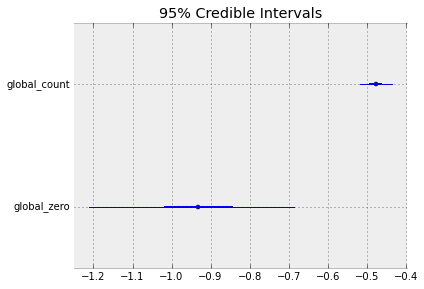

In [31]:
# Posterior summary plot
plt.style.use('bmh')
pm.Matplot.summary_plot([M.kappa_0, M.gamma_0])

#### Reef-level outbreak probabilities

Could not calculate Gelman-Rubin statistics. Requires multiple chains of equal length.


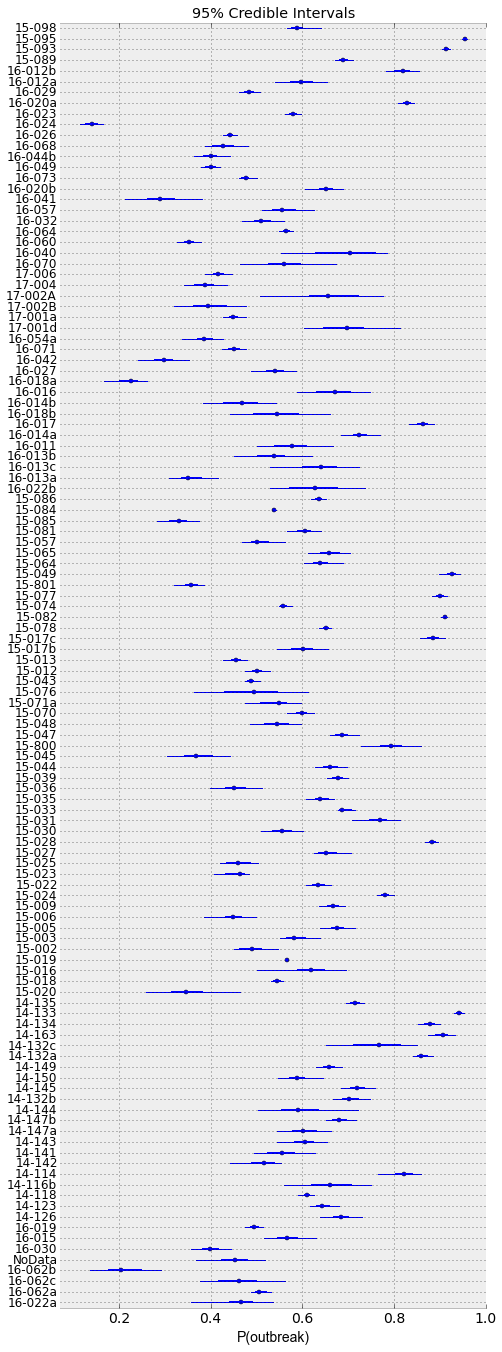

In [32]:
plt.figure(figsize=(7,21))
pm.Matplot.summary_plot(M.pReef, custom_labels=Reef)
#"""
#plt.plot(obsOut,-np.array(range(1,len(obsOut)+1)),'r.')
# Plot pretty
axis_font = {'fontname':'Arial', 'size':'14'}
plt.xlabel('P(outbreak)',**axis_font)
plt.tick_params(axis='x', labelsize=14)
plt.tick_params(axis='y', labelsize=12)
#"""

#### Reef-level expected density in an outbreak

Could not calculate Gelman-Rubin statistics. Requires multiple chains of equal length.


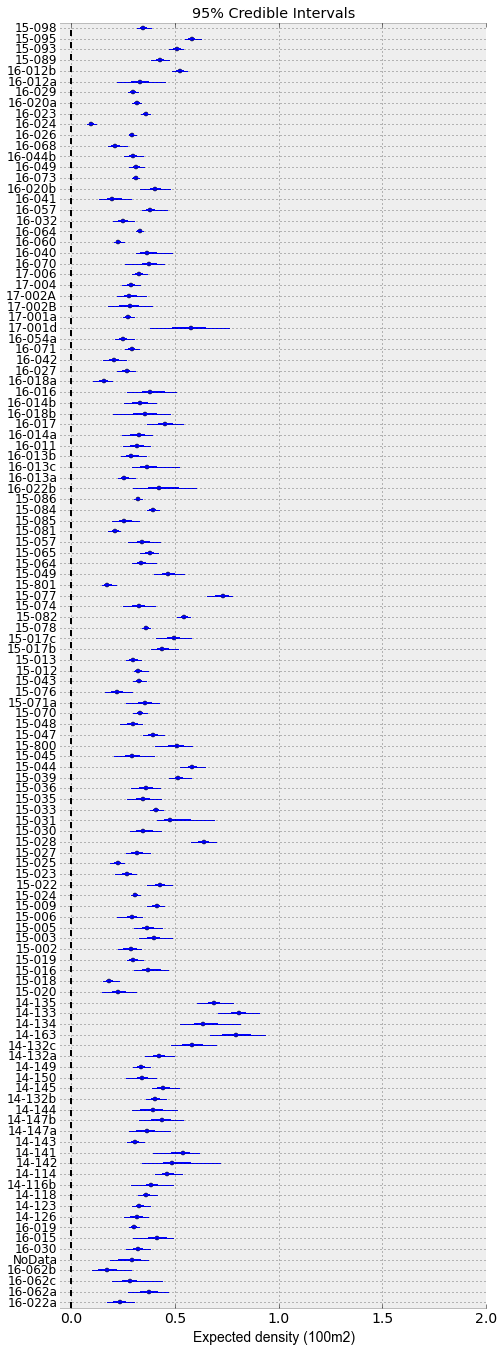

In [33]:
plt.figure(figsize=(7, 21))
axis_font = {'fontname':'Arial', 'size':'14'}
pm.Matplot.summary_plot([x for x in M.EDens_reef], x_range=(-0.05,2), custom_labels=Reef)
#plt.plot(obsDens,-np.array(range(1,nreefs+1)),'r.')
# Plot pretty
plt.xlabel('Expected density (100m2)',**axis_font)
plt.tick_params(axis='x', labelsize=14)
plt.tick_params(axis='y', labelsize=12)

Plotting global_zero


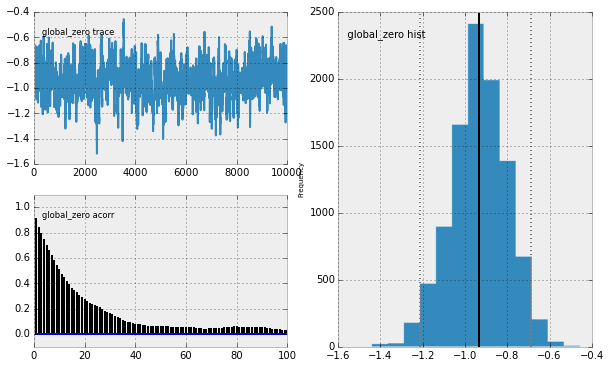

In [34]:
pm.Matplot.plot(M.gamma_0)

Plotting global_count


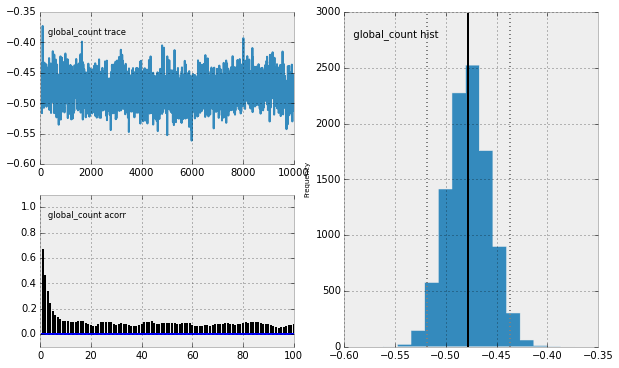

In [35]:
pm.Matplot.plot(M.kappa_0)

In [36]:
np.exp(-0.75)

0.47236655274101469

Could not calculate Gelman-Rubin statistics. Requires multiple chains of equal length.


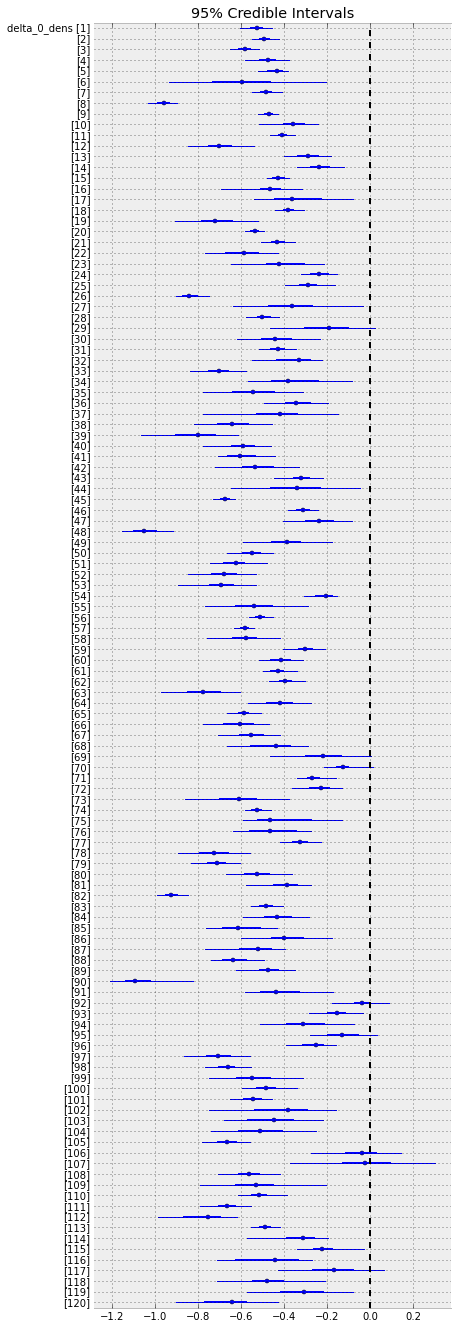

In [37]:
plt.figure(figsize=(7, 21))
pm.Matplot.summary_plot(M.delta_0)

Could not calculate Gelman-Rubin statistics. Requires multiple chains of equal length.


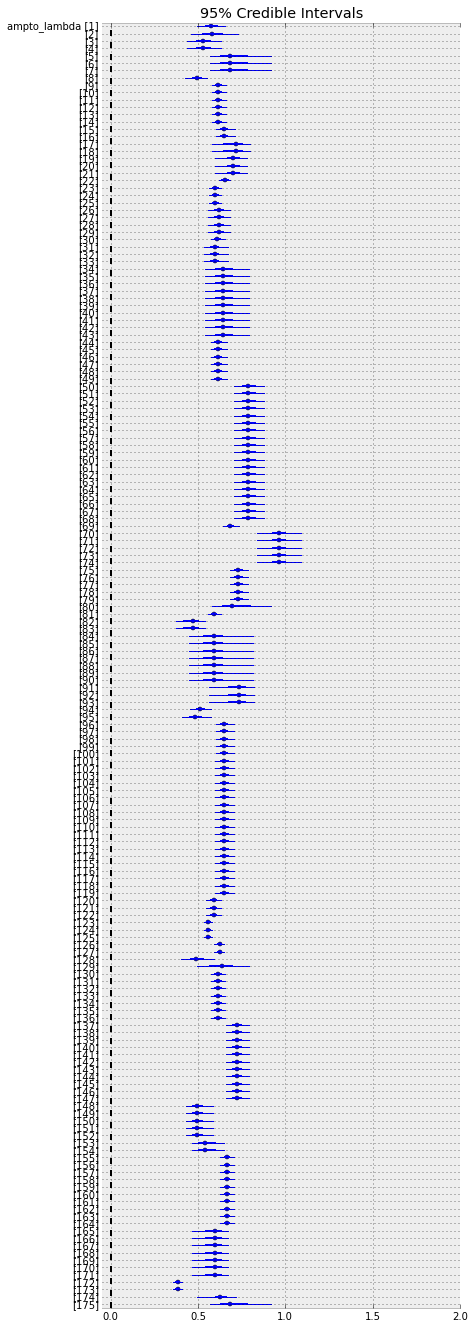

In [38]:
plt.figure(figsize=(7, 21))
pm.Matplot.summary_plot(M.ampto_lambda, x_range=(-0.05,2))

Have a look at estimated AMPTO density vs. CPUE

Plotting DLI_zero


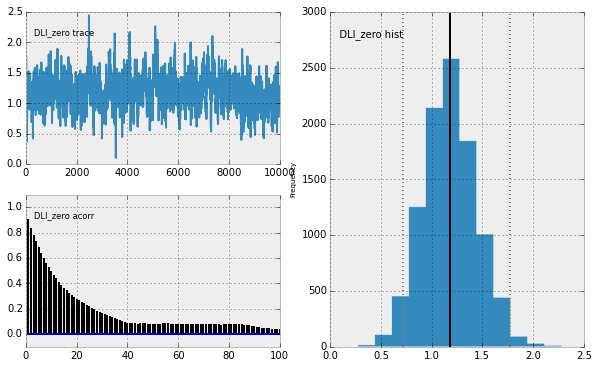

In [39]:
pm.Matplot.plot(M.gamma_1)

Plotting B


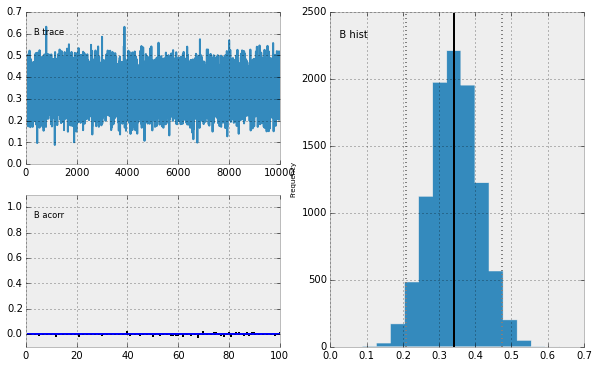

In [40]:
pm.Matplot.plot(M.B)

In [41]:
# Grab trace
MExAbu = M.AMPTO_Dens.trace().T

# Create data range
ampto_predx = np.linspace(min(lCPUE),max(lCPUE),num=10)
# Generate expected line
apreds = M.AMPTO_Preds.trace().T
ampto_predy = np.array([np.median(x) for x in apreds])

# Grab median
ExAbu = np.array([np.median(x) for x in MExAbu])
# Grab l50
ExAbu_l50 = np.array([np.percentile(x,25) for x in MExAbu])
# Grab u50
ExAbu_u50 = np.array([np.percentile(x,75) for x in MExAbu])
# Grab l95
ExAbu_l95 = np.array([np.percentile(x,2.5) for x in MExAbu])
# Grab u95
ExAbu_u95 = np.array([np.percentile(x,97.5) for x in MExAbu])

(array([ 69.,  32.,  17.,  16.,  10.,  10.,   6.,   7.,   4.,   4.]),
 array([ 0.        ,  0.12188669,  0.24377338,  0.36566007,  0.48754677,
         0.60943346,  0.73132015,  0.85320684,  0.97509353,  1.09698022,
         1.21886692]),
 <a list of 10 Patch objects>)

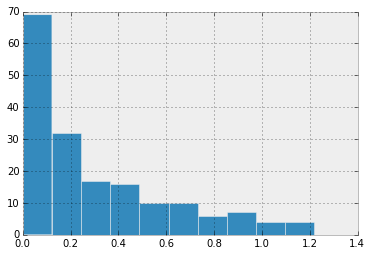

In [42]:
plt.hist(CPUE)

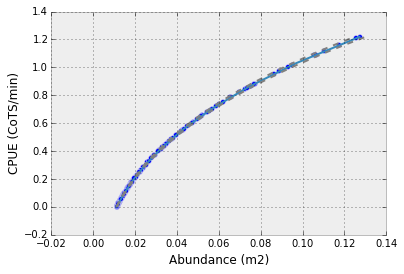

In [43]:
plt.scatter(ExAbu/100.,CPUE )
plt.plot(ampto_predy/100.,np.exp(ampto_predx)-1 )
indx = np.argsort(CPUE)
plt.plot(ExAbu_l95[indx]/100., CPUE[indx],c='.5',linestyle='--')
plt.plot(ExAbu_u95[indx]/100., CPUE[indx],c='.5',linestyle='--')
plt.scatter(ExAbu/100.,CPUE,s=25)
plt.xlabel('Abundance (m2)')
plt.ylabel('CPUE (CoTS/min)')

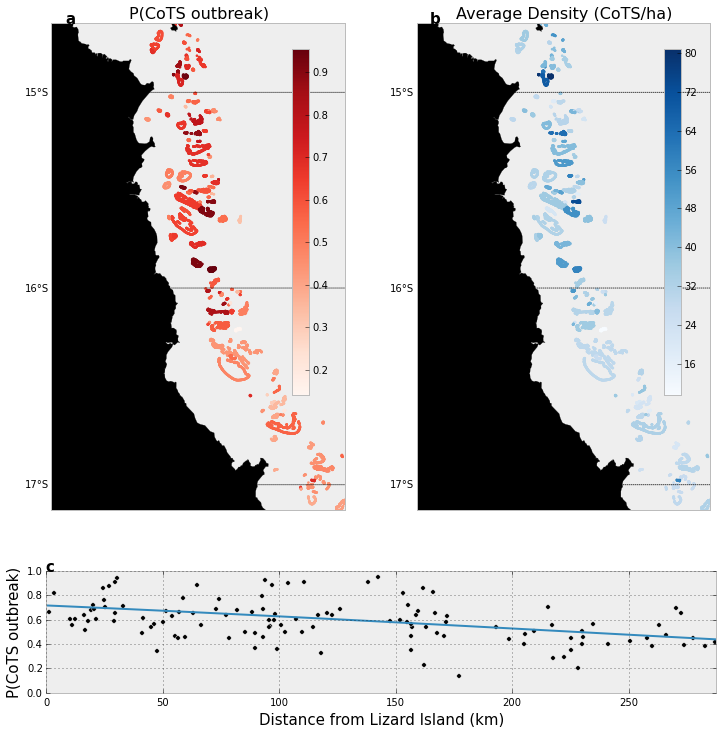

In [44]:
import matplotlib as mp


# Number of map panels
npan = 2
#fig, axes = plt.subplots(nrows=2, ncols=npan, figsize=(12,8))
#ax1, ax2 = axes.flat[0], axes.flat[1]

fig = plt.figure(figsize=(12, 12))
gs = mp.gridspec.GridSpec(2, 2,height_ratios=[4,1])
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])
ax3 = fig.add_subplot(gs[1,:])
#ax4 = fig.add_subplot(gs[1,2])


# Lat/longitudes
ymin, ymax = (cdata.Latitude.min(),cdata.Latitude.max())
xmin, xmax = (cdata.Longitude.min(),cdata.Longitude.max())
xmin = xmin-.5



### ======================================= P(outbreak) - a =================================== ###

# Map projection
#plt.figure(figsize=(12, 12))
mapx = bm(projection='merc',llcrnrlat=ymin, llcrnrlon=xmin,urcrnrlon=xmax,urcrnrlat=ymax,resolution='h',ax=ax1)
# Manta-tow locations
xlon,ylat = mapx(cdata.Longitude.values,cdata.Latitude.values)

# Probability of outbreak
PoutReef = M.pReef.trace().T
pReef = np.array([np.median(x) for x in PoutReef])[Ir]

# Plot
im1 = ax1.scatter(xlon,ylat,edgecolors='none',s=7,c=pReef,cmap=mp.cm.Reds)

# Draw map
mapx.drawcoastlines(linewidth=0.25)
mapx.drawcountries(linewidth=0.25)
mapx.drawmeridians(np.arange(148,152,1),labels=[1,0,0,1],fontsize=10)
mapx.drawparallels(np.arange(-25,17,1),labels=[1,0,0,0],fontsize=10)
mapx.fillcontinents(color='black',lake_color='aqua')

# Add Makay
#xpt,ypt = map(149.185850,-21.141216)
#plt.scatter(xpt,ypt,70,marker='^',color='red')
#plt.text(xpt-25000,ypt,"Mackay",color='white',fontsize=14)
ax1.set_title('P(CoTS outbreak)', fontsize=16)
ax1.tick_params(labelsize=14)
ax1.annotate('a', (min(xlon)-47000,max(ylat)),fontsize=15, fontweight='bold')
cbar_ax1 = fig.add_axes([0.41, 0.47, 0.02, 0.4])
fig.colorbar(im1, cax=cbar_ax1)


### ======================================= CoTS density - b =================================== ###
mapx = bm(projection='merc',llcrnrlat=ymin, llcrnrlon=xmin,urcrnrlon=xmax,urcrnrlat=ymax,resolution='h',ax=ax2)
xlon,ylat = mapx(cdata.Longitude.values,cdata.Latitude.values)

# Average density
dReef = np.array([np.median(x.trace()) for x in M.EDens_reef])[Ir]*100.

# Plot
im2 = ax2.scatter(xlon,ylat,edgecolors='none',s=7,c=dReef,cmap=mp.cm.Blues)

# Map
mapx.drawcoastlines(linewidth=0.25)
mapx.drawcountries(linewidth=0.25)
mapx.drawmeridians(np.arange(148,152,1),labels=[1,0,0,1],fontsize=10)
mapx.drawparallels(np.arange(-25,17,1),labels=[1,0,0,0],fontsize=10)
mapx.fillcontinents(color='black',lake_color='aqua')

# Add Makay
#xpt,ypt = map(149.185850,-21.141216)
#plt.scatter(xpt,ypt,70,marker='^',color='red')
#plt.text(xpt-25000,ypt,"Mackay",color='white',fontsize=14)
ax2.set_title('Average Density (CoTS/ha)', fontsize=16)
ax2.tick_params(labelsize=14)
ax2.annotate('b', (min(xlon)-47000,max(ylat)),fontsize=15, fontweight='bold')
cbar_ax2 = fig.add_axes([0.84, 0.47, 0.02, 0.4])
fig.colorbar(im2, cax=cbar_ax2)


### ======================================= Distance from Lizard Effect - c =================================== ###
# Calculate relationship to distance from Lizard
xnew = np.linspace(0,maxDLI)
g0 = np.median(M.gamma_0.trace())
g1 = np.median(gamma_1.trace())
ynew = 1.-pm.invlogit(g0+g1*(xnew/maxDLI))

# Grab P(outbreak)
pout = np.array([np.median(x) for x in M.pReef.trace().T])

# Plot
ax3.plot(xnew,ynew)
ax3.scatter(DLI*maxDLI,pout,c='black')

# Prettify
ax3.set_ylim(0,1)
ax3.set_xlim(-0.2,maxDLI+0.2)
ax3.annotate('c', (0, 1) ,fontsize=15, fontweight='bold')
ax3.set_xlabel('Distance from Lizard Island (km)',fontsize=15)
ax3.set_ylabel('P(CoTS outbreak)',fontsize=15)

fig.savefig('Figure_4.pdf')



In [45]:
np.percentile(dReef,95)

58.204656264085685

(array([  8.73000000e+03,   2.31000000e+02,   6.30000000e+01,
          3.40000000e+01,   8.00000000e+00,   1.10000000e+01,
          9.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          3.00000000e+00]),
 array([  0.        ,   2.99681631,   5.99363262,   8.99044893,
         11.98726524,  14.98408155,  17.98089786,  20.97771417,
         23.97453048,  26.97134679,  29.9681631 ]),
 <a list of 10 Patch objects>)

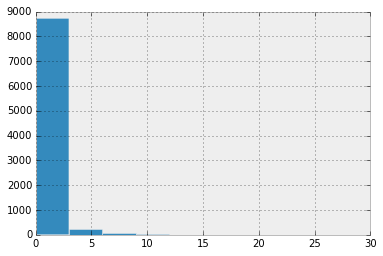

In [46]:
plt.hist(density)

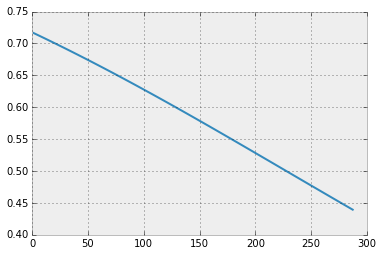

In [47]:
plt.plot(xnew,ynew)

In [48]:
9145./125.

73.16

In [49]:
125*73.

9125.0

In [50]:
g1

1.1753328978739304